In [16]:
# Cell 1
import os
import sys
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.clean_data import load_and_basic_clean, flag_zscore_outliers, impute_median, export_clean

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

In [17]:
# Cell 2
RAW_PATH = "../data/togo-dapaong_qc.csv" 
df_raw = pd.read_csv(RAW_PATH)

print("Raw shape:", df_raw.shape)
print("\nData types and non-null counts:")
display(df_raw.info())

print("\nSummarry statistics for numeric columns:")
display(df_raw.describe().T)

print("\nMissing value counts:")
display(df_raw.isna().sum())

print("\nColumns with >5% nulls:")
total = len(df_raw)
null_pct = (df_raw.isna().sum() / total) * 100
print(null_pct[null_pct > 5].sort_values(ascending=False))

Raw shape: (525600, 19)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          52

None


Summarry statistics for numeric columns:


,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,230.555040,322.532347,-12.7,-2.2,2.1,442.400,1424.0
DNI,525600.0,151.258469,250.956962,0.0,0.0,0.0,246.400,1004.5
DHI,525600.0,116.444352,156.520714,0.0,0.0,2.5,215.700,805.7
ModA,525600.0,226.144375,317.346938,0.0,0.0,4.4,422.525,1380.0
ModB,525600.0,219.568588,307.932510,0.0,0.0,4.3,411.000,1367.0
Tamb,525600.0,27.751788,4.758023,14.9,24.2,27.2,31.100,41.4
RH,525600.0,55.013160,28.778732,3.3,26.5,59.3,80.800,99.8
WS,525600.0,2.368093,1.462668,0.0,1.4,2.2,3.200,16.1
WSgust,525600.0,3.229490,1.882565,0.0,1.9,2.9,4.400,23.1
WSstdev,525600.0,0.557740,0.268923,0.0,0.4,0.5,0.700,4.7



Missing value counts:


Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


Columns with >5% nulls:
Comments    100.0
dtype: float64


In [18]:
# Cell 3
df_clean = load_and_basic_clean(RAW_PATH, "Togo")
print("After basic cleaning:", df_clean.shape)
display(df_clean.head())

After basic cleaning: (525600, 19)


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Country
Timestamp,,,,,,,,,,,,,,,,,,,
2021-10-25 00:01:00,0.0,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN,Togo
2021-10-25 00:02:00,0.0,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN,Togo
2021-10-25 00:03:00,0.0,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN,Togo
2021-10-25 00:04:00,0.0,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN,Togo
2021-10-25 00:05:00,0.0,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN,Togo


In [19]:
# Cell 4
cols_to_check = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']
df_flagged = flag_zscore_outliers(df_clean, cols_to_check)

# Count rows flagged for any of the zscore outliers
zcols = [c for c in df_flagged.columns if c.endswith('_z_outlier')]
df_flagged['any_z_outlier'] = df_flagged[zcols].any(axis=1)
print("Total rows flagged as outlier (|Z|>3) for any metric:", df_flagged['any_z_outlier'].sum())

Total rows flagged as outlier (|Z|>3) for any metric: 525600


In [20]:
# Cell 5
# Choose columns to impute (key sensor and irradiance columns)
impute_cols = ['GHI','DNI','DHI','ModA','ModB','Tamb','RH']
df_imputed = impute_median(df_flagged.copy(), impute_cols)

# verify no nulls remain in these key columns
display(df_imputed[impute_cols].isna().sum())

GHI     0
DNI     0
DHI     0
ModA    0
ModB    0
Tamb    0
RH      0
dtype: int64

In [21]:
# Cell 6
import os
os.makedirs("../data", exist_ok=True)
export_clean(df_imputed, "../data/togo_clean.csv")
print("Exported ../data/togo_clean.csv (do NOT commit this file)")

Exported ../data/togo_clean.csv (do NOT commit this file)


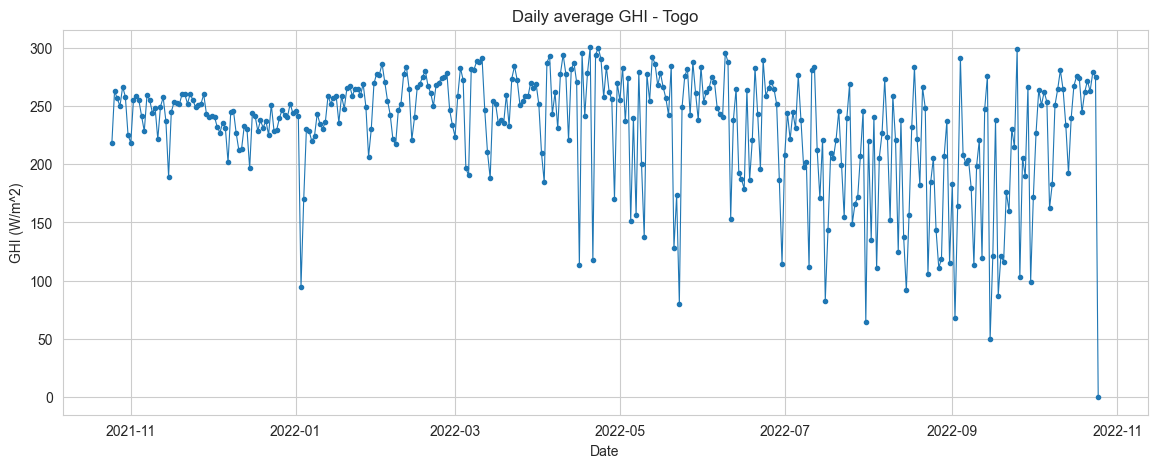

In [22]:
# Cell 7 - daily avg GHI line
df_daily = df_imputed.resample('D').mean(numeric_only=True)
plt.figure(figsize=(14,5))
plt.plot(df_daily.index, df_daily['GHI'], marker='.', linewidth=0.8)
plt.title('Daily average GHI - Togo')
plt.ylabel('GHI (W/m^2)')
plt.xlabel('Date')
plt.show()

In [23]:
# Cell 8
if 'Cleaning' in df_imputed.columns:
    before = df_imputed[df_imputed['Cleaning'] == 0][['ModA','ModB']].mean()
    after = df_imputed[df_imputed['Cleaning'] == 1][['ModA','ModB']].mean()
    print("Average before cleaning:\n", before)
    print("Average after cleaning:\n", after)
else:
    print("No Cleaning column found.")

Average before cleaning:
 ModA    225.979064
ModB    219.401351
dtype: float64
Average after cleaning:
 ModA    535.186477
ModB    532.211744
dtype: float64


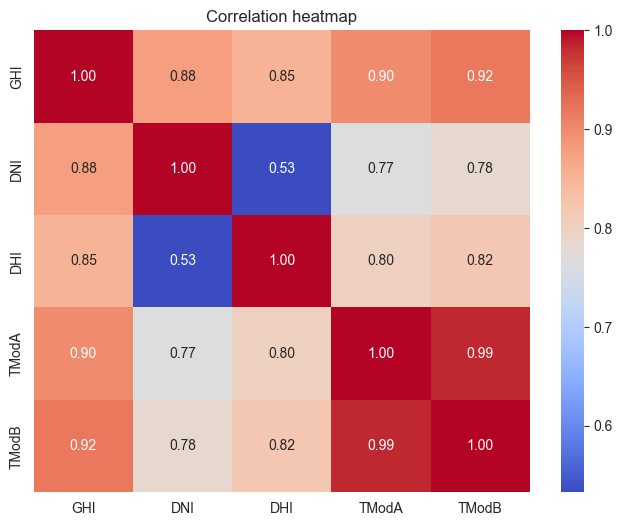

In [24]:
# Cell 9
corr_cols = ['GHI','DNI','DHI','TModA','TModB']
corr_df = df_imputed[corr_cols].dropna()
plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation heatmap")
plt.show()

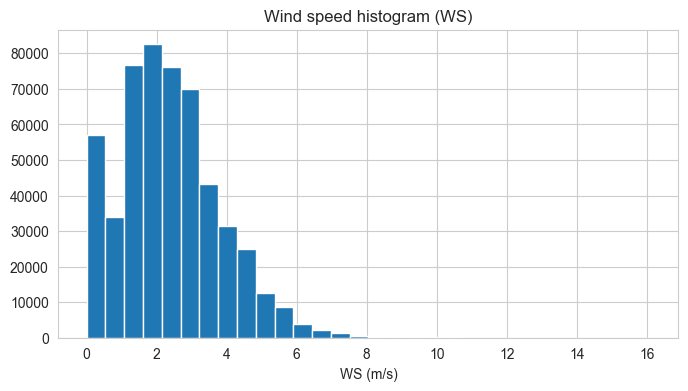

In [25]:
# Cell 10 - histogram for WS
plt.figure(figsize=(8,4))
df_imputed['WS'].dropna().hist(bins=30)
plt.title('Wind speed histogram (WS)')
plt.xlabel('WS (m/s)')
plt.show()

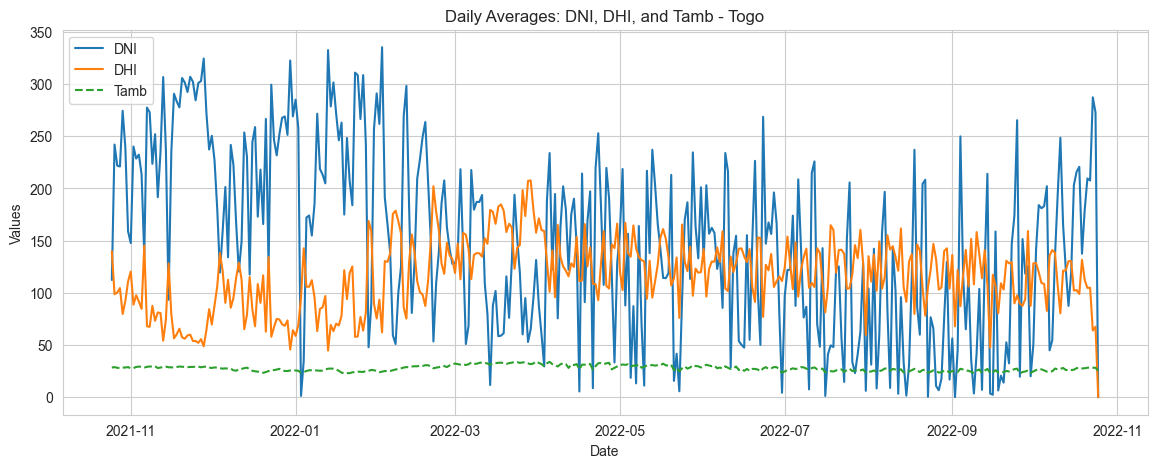

In [26]:
# Cell 11 — Additional time series plots
df_daily_avg = df_imputed.resample('D').mean(numeric_only=True)

plt.figure(figsize=(14,5))
plt.plot(df_daily_avg.index, df_daily_avg['DNI'], label='DNI')
plt.plot(df_daily_avg.index, df_daily_avg['DHI'], label='DHI')
plt.plot(df_daily_avg.index, df_daily_avg['Tamb'], label='Tamb', linestyle='--')
plt.title('Daily Averages: DNI, DHI, and Tamb - Togo')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

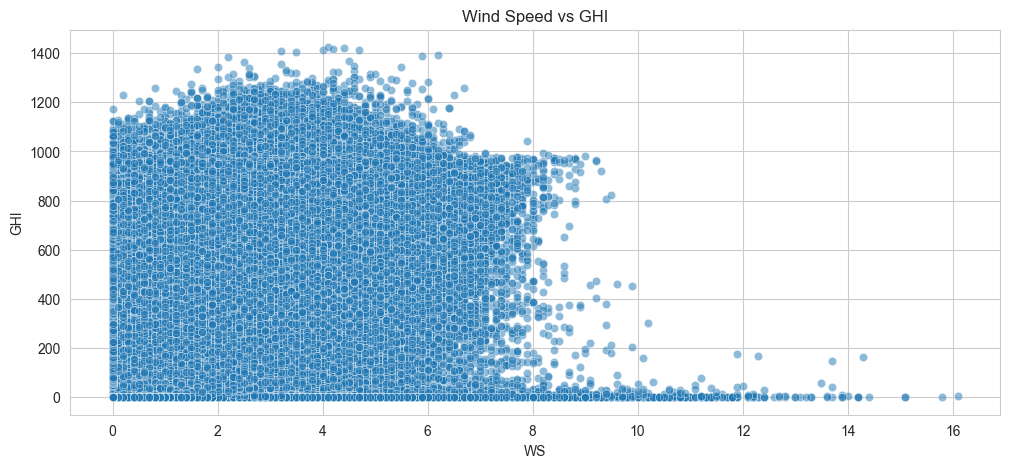

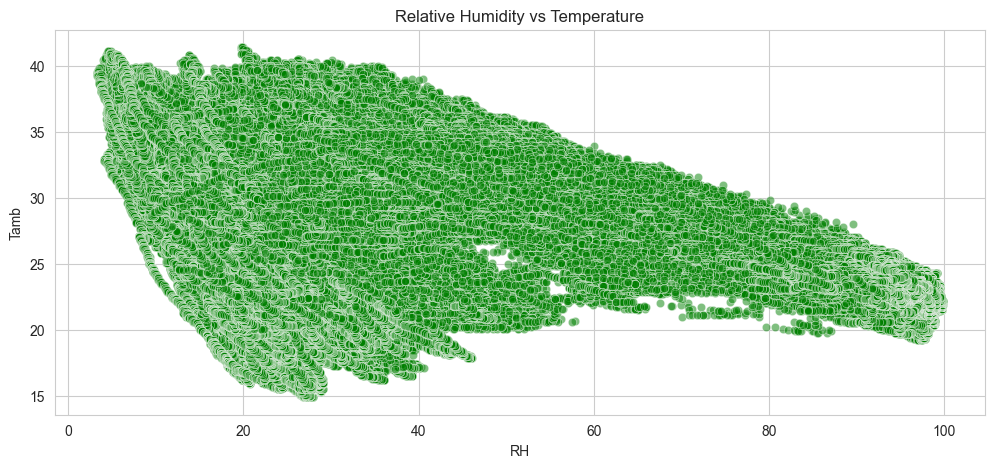

In [27]:
# Cell 12 — Scatter plots
plt.figure(figsize=(12,5))
sns.scatterplot(x='WS', y='GHI', data=df_imputed, alpha=0.5)
plt.title('Wind Speed vs GHI')
plt.show()

plt.figure(figsize=(12,5))
sns.scatterplot(x='RH', y='Tamb', data=df_imputed, alpha=0.5, color='green')
plt.title('Relative Humidity vs Temperature')
plt.show()

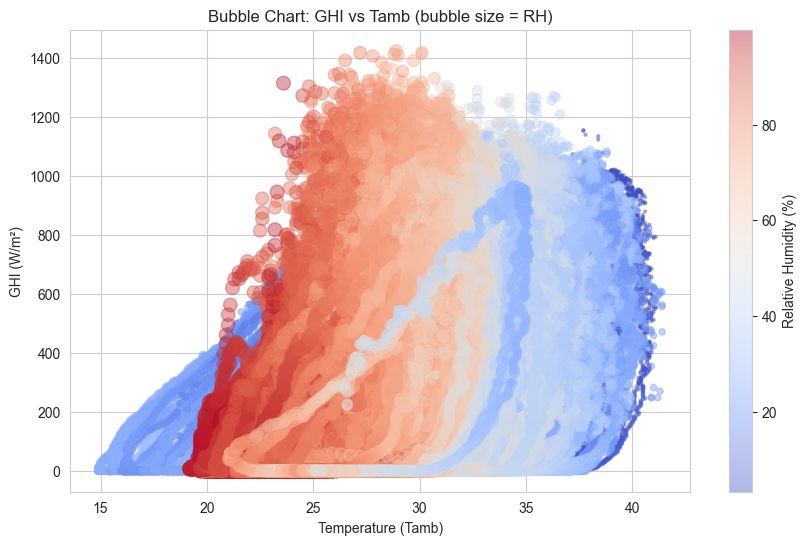

In [28]:
# Cell 13 — Bubble chart
plt.figure(figsize=(10,6))
plt.scatter(
    df_imputed['Tamb'],
    df_imputed['GHI'],
    s=df_imputed['RH'], # bubble size = humidity
    alpha=0.4,
    c=df_imputed['RH'],
    cmap='coolwarm'
)
plt.title('Bubble Chart: GHI vs Tamb (bubble size = RH)')
plt.xlabel('Temperature (Tamb)')
plt.ylabel('GHI (W/m²)')
plt.colorbar(label='Relative Humidity (%)')
plt.show()